In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler


# More NLP

## Truncated Singular Value Decomposition and Dimensionality Reduction

When processing text we end up with feature sets that are large! There is up to one feature per different word in our text sample, as well as more for multi-word combinations if there are larger ngrams allowed, far larger than a typical feature set that we're used to. One thing we can do when vectorizing is just to cap the number of features we end up with, but that doesn't seem to be the most sophisticated or smartest approach. 

TSVD is one thing that we can do to chop down the feature set - or reduce the dimensions - with a little more thought. 

## Dimensionality Reduction

Dimensionality reduction is a common technique in machine learning, it does its name - reduces the dimensions in our feature data. We often want to do this for several reasons: 
<ul>
<li> To reduce the amount of time it takes to train a model.
<li> To reduce the amount of memory required to store the data.
<li> To reduce the amount of noise in the data.
<li> To make the data more interpretable.
<li> To make the data more amenable to visualization.
</ul>

#### Load Dataset from Last Time

We'll load the spam dataset and vectorize it with TF-IDF.

In [4]:
#Load Data
df = pd.read_csv("data/spam.csv", encoding="ISO-8859-1")
df.drop(columns={"Unnamed: 2", "Unnamed: 3", "Unnamed: 4"}, inplace=True)
df.rename(columns={"v1":"target", "v2":"text"}, inplace=True)
#TF-IDF
vec_tf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,4), stop_words="english", strip_accents="unicode")
tmp = vec_tf.fit_transform(df["text"])
tok_cols = vec_tf.get_feature_names()
tok_df = pd.DataFrame(tmp.toarray(), columns=tok_cols)
print("original:", df["text"].shape)
print("vectorized:", tmp.shape)
y = df["target"]
X = df["text"]
tok_df.sample(5)

original: (5572,)
vectorized: (5572, 89635)


c:\Users\dlee2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,00 easter,00 easter prize,00 easter prize draw,00 sub,00 sub 16,00 sub 16 remove,00 sub 16 unsub,00 subs,00 subs 16,...,zoom cine actually,zoom cine actually tonight,zouk,zouk nichols,zouk nichols paris,zouk nichols paris free,zyada,zyada kisi,zyada kisi ko,zyada kisi ko kuch
4574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## LSA - Latent Semantic Analysis

The TSVD performs somehting called latent semantic analysis. The process of LSA and the math behind it are not something we need to explore in detail. (LSA is often called LSI - Latent Semantic Indexing). The idea of LSA is that it can generate "concepts" in the text. These concepts are found by looking at which terms occur in which documents - documents that have the same terms repeated are likely related to the same concept; other documents that share other words with those documents are likely on the same concept as well.  

An important part is the word "Latent" - i.e. the patterns detected are hidden, not explicit in the data. 

#### Implement SVD to Trim Dataset

We are starting with LOTS of feature inputs. Below we can loop through several models of different number of remaining components to see the accuracy depending on the number of features we keep in the feature set. The truncated part of truncated SVD trims the featureset down to the most significant features. 

We started with a lot of features - we can make predictions that are close to as accurate with far fewer, hopefully!

<b>Note:</b> this might take a long time to run, depending on your computer. Change the "for i in range()" part to cut down on the number of iterations to make it run faster.

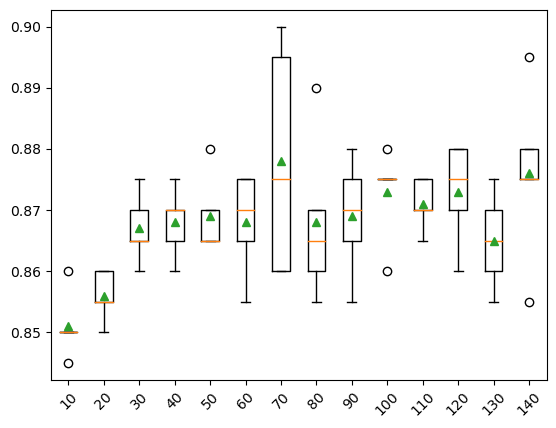

In [6]:
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,15):
		n = i*10
		steps = [('svd', TruncatedSVD(n_components=n)), ('m', LinearSVC(max_iter=100, tol=.01))]
		models[str(n)] = Pipeline(steps=steps)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	#Splits cut for speed
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, tok_df[0:1000], y[0:1000])
	results.append(scores)
	names.append(name)
# plot model performance for comparison

plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

#### Prepare Datasets

In [7]:
tf_idf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), stop_words="english", strip_accents="unicode")
tmp_vec = tf_idf.fit_transform(df["text"])

tok_cols2 = tf_idf.get_feature_names()
tmp_df = pd.DataFrame(tmp_vec.toarray(), columns=tok_cols2)


c:\Users\dlee2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
print(df["text"].sample(10))

3830    Let's pool our money together and buy a bunch ...
4807    What's up my own oga. Left my phone at home an...
3134    Wat makes some people dearer is not just de ha...
619     Let there be snow. Let there be snow. This kin...
368                            Wat uniform? In where get?
2183    Chinatown got porridge, claypot rice, yam cake...
1396                             Shall i start from hear.
1641    Hi , where are you? We're at  and they're not ...
1515                    I wonder if you'll get this text?
4711    Thats cool princess! I will cover your face in...
Name: text, dtype: object


In [9]:
X_tr, X_te, y_tr, y_te = train_test_split(tmp_df, y)

#### Baseline Accuracy

Since we are planning on dropping a bunch of data, we can try a model first to see what the baseline accuracy is. I'm also going to limit the number of features here, since using the entire dataset will take ages. 

In [10]:
tf_idf_base = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), stop_words="english", strip_accents="unicode", max_features=2000)
tmp_vec_base = tf_idf_base.fit_transform(df["text"])

tok_cols2_base = tf_idf_base.get_feature_names()
tmp_df_base = pd.DataFrame(tmp_vec_base.toarray(), columns=tok_cols2_base)
X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(tmp_df_base, y)

pipe_steps = [("scale", StandardScaler()), ("model", SVC())]
pipe_test = Pipeline(steps=pipe_steps)

pipe_test.fit(X_tr_base, y_tr_base)
pipe_test.score(X_te_base, y_te_base)

c:\Users\dlee2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0.9676956209619526

#### Implement LSA and Model

We can use the truncated SVD to reduce the number of features in our dataset, in much the way we'd use any other data preparation step in a pipeline. 

In [11]:
svd_tmp = TruncatedSVD(n_components=10)
pipe_steps = [("scale", StandardScaler()), ("svd", svd_tmp), ("model", SVC())]
pipe_test = Pipeline(steps=pipe_steps)

pipe_test.fit(X_tr, y_tr)
pipe_test.score(X_te, y_te)

0.873653984206748

In [12]:
pd.DataFrame(svd_tmp.transform(X_tr))

c:\Users\dlee2\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but TruncatedSVD was fitted without feature names
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9
0,0.000862,0.000568,-0.000207,0.000098,0.000585,-0.000926,-0.000325,0.000378,0.000742,-0.000217
1,-0.000126,-0.000134,-0.000136,-0.000098,0.000034,-0.000127,0.000337,-0.000298,0.000065,-0.000188
2,-0.000114,-0.000140,-0.000126,-0.000132,-0.000204,0.000649,-0.000373,0.000143,-0.000303,-0.000309
3,-0.000214,-0.001158,-0.000782,-0.000003,0.003139,-0.001619,0.012308,0.018555,-0.019521,0.009948
4,-0.000132,-0.000150,-0.000196,-0.000101,0.000181,-0.000042,0.000815,0.001073,0.000073,0.000235
...,...,...,...,...,...,...,...,...,...,...
4174,0.000272,-0.000180,0.002259,-0.003873,-0.006798,-0.012376,-0.000302,-0.025364,0.011336,-0.066377
4175,-0.000538,-0.000422,-0.000358,-0.000399,-0.002906,0.001415,0.000487,0.003484,-0.001652,0.010403
4176,0.001153,-0.000264,-0.000350,0.000425,-0.000092,-0.000304,0.000531,0.000434,-0.000200,0.000136
4177,-0.000422,-0.000055,-0.000465,0.002281,0.001004,-0.002038,0.001789,-0.019616,0.003031,0.012268


In [13]:
for index, component in enumerate(svd_tmp.components_):
    zipped = zip(tok_cols2, component)
    top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:6]
    top_terms_list = list(dict(top_terms_key).keys())
    print("Topic:"+str(index)+" ", top_terms_list)

Topic:0  ['gt good', 'lt gt good', 'boyfriend', 'driver', 'gt clean', 'gt true']
Topic:1  ['amp imf', 'amp imf loan', 'bank amp', 'bank amp imf', 'bank directors', 'bank directors says']
Topic:2  ['cn', '2gthr', '2gthr drinking', '2gthr drinking boost', 'aproach', 'aproach gal']
Topic:3  ['breath', 'craziest', 'curry', 'planet', 'singing', 'thoughts']
Topic:4  ['afternoon wife', 'afternoon wife called', 'arrested murderer', 'arrested murderer immediately', 'called police', 'called police police']
Topic:5  ['atlast', 'waited', '1stone', '1stone sun', '1stone sun rose', 'amp sack']
Topic:6  ['academic', 'department', 'academic department', 'academic department tell', 'academic secretary', 'academic secretary current']
Topic:7  ['lovers', 'whn', 'avoids', 'avoids problems', 'avoids problems sent', 'becz']
Topic:8  ['shahjahan', 'mumtaz', '4th wife', '4th wife wifes', 'arises', 'arises hell']
Topic:9  ['shahjahan', 'mumtaz', '4th wife', '4th wife wifes', 'arises', 'arises hell']


#### LSA Results

In the second model, our feature set is far smaller, but we're still getting a very high accuracy. If the original dataset that we started with was very large, this impact would be magnified greatly. In general, NLP models use a lot of data, so this dimesionality reduction can help reduce training datasets that are massive and may even be impractical to process. 

##### Topics

One of the things that LSA can do is to find "topics" in the text. We can use the components of the SVD to find the most important words in each topic. A "topic" is something that is not explicitly stated in the text, but is implied by the words that are used - if we have several documents that tend to use the same words, they are likely to be about the same topic. The LSA process is able to look for these cooccuring words and the documents that contain them, and group them as being about the same topic. The mechanics of this are some matrix math that is beyond what we neeed to know, but we can picture it like this.

![LSA Math](images/lsa_math.webp "LSA Math")

The topic extraction is also an example of unsupervised learning - something we'll look at more soon with clustering. We don't provide the topics to the mode in advance like we woud with a normal classification - we just give the LSA process the data, and it figures it out on its own.

The model doesn't "understand" what each topic is, but it is able to pick up on trends of tokens that tend to occur together in documents. Text that contains "ball", "game", "football", "play", "quarterback" is likely to be about football - the model won't know it is football, but it will know that those words tend to occur together, and documetns that contain those words are likely to be about the same topic. 

In [14]:
for index, component in enumerate(svd_tmp.components_):
    zipped = zip(tok_cols2, component)
    top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:6]
    top_terms_list = list(dict(top_terms_key).keys())
    print("Topic:"+str(index)+" ", top_terms_list)

Topic:0  ['gt good', 'lt gt good', 'boyfriend', 'driver', 'gt clean', 'gt true']
Topic:1  ['amp imf', 'amp imf loan', 'bank amp', 'bank amp imf', 'bank directors', 'bank directors says']
Topic:2  ['cn', '2gthr', '2gthr drinking', '2gthr drinking boost', 'aproach', 'aproach gal']
Topic:3  ['breath', 'craziest', 'curry', 'planet', 'singing', 'thoughts']
Topic:4  ['afternoon wife', 'afternoon wife called', 'arrested murderer', 'arrested murderer immediately', 'called police', 'called police police']
Topic:5  ['atlast', 'waited', '1stone', '1stone sun', '1stone sun rose', 'amp sack']
Topic:6  ['academic', 'department', 'academic department', 'academic department tell', 'academic secretary', 'academic secretary current']
Topic:7  ['lovers', 'whn', 'avoids', 'avoids problems', 'avoids problems sent', 'becz']
Topic:8  ['shahjahan', 'mumtaz', '4th wife', '4th wife wifes', 'arises', 'arises hell']
Topic:9  ['shahjahan', 'mumtaz', '4th wife', '4th wife wifes', 'arises', 'arises hell']


### Exercise - Truncated SVD

Try to use the same text for predictions from the newsgroups last time. Try to use the TSVD with a limited number of components and see if the accuracy can stay similar to what we got last time. 

In [15]:
from sklearn.datasets import fetch_20newsgroups
remove = ("headers", "footers", "quotes")
categories = ["alt.atheism", "talk.religion.misc"]

data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42, remove=remove)

data_test = fetch_20newsgroups(
    subset="test", categories=categories, shuffle=True, random_state=42, remove=remove)

##### Vectorize and Prep Data

In [16]:
# Vectorize and prep datasets
news_tf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), stop_words="english", strip_accents="unicode")
X_train = news_tf.fit_transform(data_train.data)
y_train = data_train.target
X_test = news_tf.transform(data_test.data)
y_test = data_test.target
print("Train (x,y):", X_train.shape, "  Test (x,y):", X_test.shape)

Train (x,y): (857, 153056)   Test (x,y): (570, 153056)


##### Create Models

In [17]:
# Create Models
tsvd = TruncatedSVD(n_components=20)
news_steps = [("scale", StandardScaler(with_mean=False)), ('svd', tsvd), ('m', RandomForestClassifier())]
news_model = Pipeline(steps=news_steps)
news_model.fit(X_train, y_train)
news_model.score(X_test, y_test)

0.5140350877192983

In [18]:
pd.DataFrame(tsvd.transform(X_train))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000388,0.000826,0.000519,0.000964,0.000555,0.000270,0.000458,0.000350,0.000579,0.000433,0.000569,0.000291,0.000706,0.000762,0.000496,0.000564,0.000270,0.000143,0.001342,0.000753
1,0.000549,0.000779,0.001020,0.000972,0.000489,0.000440,0.000611,0.000956,0.001621,0.003187,0.000865,0.000616,0.001983,0.000166,0.000177,0.001389,0.001244,0.000810,0.001812,0.000361
2,0.000671,0.000397,0.000511,0.000361,0.000516,0.000285,0.000089,0.000339,0.000656,0.000692,0.000435,0.000341,0.000731,0.000579,0.000208,0.002418,0.000339,0.000105,0.000609,-0.000009
3,0.000389,0.000460,0.000312,0.000368,0.000328,0.000148,0.000337,0.000139,0.000879,0.000539,0.000766,0.000291,0.000525,0.000831,0.000269,0.001352,0.000317,-0.000070,0.000625,0.000130
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,0.000274,0.000801,0.001144,0.000395,0.000539,0.000203,0.000530,0.001075,0.000604,0.000317,0.000898,0.000495,0.000220,0.000804,0.000502,0.000764,0.000811,0.000982,0.000945,0.000448
853,0.000938,0.000459,0.000591,0.000275,0.000494,0.001337,0.000420,0.000520,0.001067,0.000356,0.002006,0.001405,0.001969,0.000342,0.000066,0.000466,0.000458,-0.000089,0.002580,0.000946
854,0.000427,0.000753,0.000371,0.000836,0.000989,0.000207,0.000403,0.001117,0.000708,0.000771,0.000425,0.000353,0.000353,0.000877,0.000402,0.000727,0.001254,-0.000005,0.001292,0.000060
855,0.000628,0.000693,0.000216,0.000594,0.000351,0.000637,0.000156,0.000903,0.000777,0.000763,0.000672,0.000117,0.000379,0.001399,0.000014,0.001038,0.001007,-0.001073,0.002495,0.000277


##### Look at the Topics

We can also take a look at what the topics identified in the data are. 

In [19]:
terms = news_tf.get_feature_names()
topics = []
for index, component in enumerate(tsvd.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

c:\Users\dlee2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['000 years christians', '000 years prophecies', '000 years waited', '10 throwing', '10 throwing pieces']
Topic 1:  ['according definition', 'according definition atheism', 'adopt', 'aren atheists', 'ask atheists']
Topic 2:  ['10 1797', '10 1797 recently', '1070', '1070 1080', '1070 1080 english']
Topic 3:  ['argument premises', 'fallacy occurs', 'general rule', 'abusive', 'accent']
Topic 4:  ['02 32', '02 32 11', '11 1993', '11 1993 basically', '11 1993 owe']
Topic 5:  ['12 old', '12 old persian', '12 saoshyant', '12 saoshyant sasanid', '1938 boyce']
Topic 6:  ['071', '071 430', '1000 berlin', '1000 berlin 41', '41 germany']
Topic 7:  ['1981 hell', '1981 hell broke', '1985 david', '1985 david caligiuri', '1985 months']
Topic 8:  ['local zoroastrians', '000 years benign', '000 zoroastrians', '000 zoroastrians entire', '10 acre']
Topic 9:  ['introns', '1992 petri', '_believe_ healthy', '_believe_ healthy sign', '_evidence_']
Topic 10:  ['1066', '1066 z1dan', '1066 z1dan exnet'

### LSA Results

Using LSA is a good way to condense our feature set that is often extremely large and extremely sparse, especially when we are dealing a large dataset, as is common with NLP. 

Simple applications in which this technique is used are documented clustering in text analysis, recommender systems, and information retrieval. More detailed use-cases of topic modeling are:
<ul>
<li> <b>Resume Summarization:</b> It can help recruiters to evaluate resumes by a quick glance. They can reduce effort in filtering pile of resume.
<li> <b>Search Engine Optimization:</b> online articles, blogs, and documents can be tag easily by identifying the topics and associated keywords, which can improve optimize search results.
<li> <b>Recommender System Optimization:</b> recommender systems act as an information filter and advisor according to the user profile and previous history. It can help us to discover unvisited relevant content based on past visits.
<li> <b>Improving Customer Support:</b> Discovering relevant topics and associated keywords in customer complaints and feedback for examples product and service specifications, department, and branch details. Such information help company to directly rotated the complaint in respective department.
<li> <b>Healthcare Industry:</b> topic modeling can help us to extract useful and valuable information from unstructured medical reports. This information can be used for patients treatment and medical science research purpose.
</ul>

In general, non-neural network approaches to NLP tend to be present in areas where we need to be able to process text quickly, without lots of processing. Spam filters are the classic example - we need to say yes or no, without spending ages to do so or burdening an email service with lots of processing. The examples above are similar - we are trying to draw a simple-ish conclusion. This is also somewhere that our old friend Bayes and his classifiers are most commonly seen - they are very fast at generating predictions once trained, so for something like emails, that's likely to be a good choice.

An important concept from this example is the idea of condesing multiple features down into a smaller feature set while attempting to maintain the information in the original, that is something we'll revisit with Principal Component Analysis (PCA), a similar technique that is more generally applicable, later on.

## Word2Vec and Classification

In addition to calculating things solely directly from our data, we can also use some external tools that can help create embeddings that are a little better (hopefully). This is also a neural network running behind the scenes to help us out. Word2Vec is an algorithm made by Google that can help process text and produce embeddings. Word2Vec looks for associations of words that occur with each other. This is an excellent illustrated description of Word2Vec: https://jalammar.github.io/illustrated-word2vec/

### Word2Vec in Process

Word2Vec generates its embeddings by looking at words in a sentence, and the surrounding words in that same sentence. This differs quite a bit from the data that we've generated with the vectorization, as this model is better able to capture the strutucre of a sentence, beyond only looking at the individual words. We will use word2vec for a couple of different things:
<ul>
<li> Primarily, we'll use word2vec in a "two model" sequence to set us up to do classifications. The word2vec model will replace the count/tf-idf scores that we previously used for our feature set with embeddings that it calculates as the w2v model trains. The w2v model is "learning" how to represent words with numbers, in this case dimensions in a multidimensional space.
    <ul>
    <li> The w2v training is what creates the N-dimension measurements of each token, those then feed into our feature set for our modelling. 
    </ul>
<li> After the word2vec model is created, we can do things like check the similarity of words. 
</ul>

#### Gensim

Gensim is a package that we can install that has an implementation of Word2Vec that we can use pretty easily. This part just downloads some of the stuff we'll need, like stopwords. 

In [20]:
from gensim.models import Word2Vec
nltk.download('all')
import nltk
for package in ['stopwords','punkt','wordnet', 'omw-1.4']:
    nltk.download(package) 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\dlee2\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\dlee2\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\dlee2\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\dlee2\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\dlee2\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping grammars\basque_grammars.zip.
[nltk_data]   

### Tokenizer

Since we are not using the vecorizer from sklearn, we need to provide our own tokenization. We can use the nltk based one from last time. We can also do any other types of processing here that we may want - stemming, customized stop words, etc... For this one I chopped out any 1 character tokens and added a regex filter to get rid of punctuation. 

In [21]:
class lemmaTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import WordNetLemmatizer
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                tok = re.sub('\W+','', tok) #Punctuation strip
                tmp = self.lemmatizer.lemmatize(tok)
                if len(tmp) >= 2:
                    filtered_tok.append(tmp)
        return filtered_tok

### Create Clan Text - Tokenize and Lemmatize

Prep some data. The "second half" of the dataframe is what we can use with the Word2Vec prediction models - we have cleaned up lists of tokens as well as translating the targets to 1 and 0. 

In [22]:
tok = lemmaTokenizer(stop_words)
df["clean_text"] = df["text"].apply(lambda x: tok(x))
df["target2"] = pd.get_dummies(df["target"], drop_first=True)
df.head()

,target,text,clean_text,target2
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, jurong, point, crazy, Available, bugis, g...",0
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, Joking, wif, oni]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, wkly, comp, win, FA, Cup, final,...",1
3,ham,U dun say so early hor... U c already then say...,"[dun, say, early, hor, already, say]",0
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, nt, think, go, usf, life, around, though]",0


### Create Word2Vec Ebmeddings

Now comes the word2vec model - instead of taking our clean data and counting it to extract features, we can train our Word2Vec model with our cleaned up data and the output of that model is our set of features. This will have Word2Vec do its magic behind the scenes and perform the training. W2V works in one of two ways, which are roughly opposites of each other, when doing this training:
<ul>
<li> Continuous Bag of Words: looks at a window around each target word to try to predict surrounding words.
<li> Skip-Gram: looks at words surrounding target to try to predict it. 
</ul>

We'll revisit the details of some of this stuff later on when we look at neural networks, since W2V is a neural network algorithm, it will make more sense in context. 

<b>Note:</b> this training is not making a model that we are using to make predictions. This is training inside the W2V algorithm to generate representations of our tokens. 

#### Embeddings

The embeddings that we are generating are vectors that represent the words in our text. We can look at the embeddings for a word to see what they look like, but they aren't comprehensible to humans. Our count vectors or the td-idf calculations we made previously are also embeddings, those are just far more simple. Word2Vec will generate embeddings that attempt to group words that are similar together in multidimensional space. We can look at a simple example in 2D:

![Similarity](images/similarity.png "Similarity")

The values here aren't calculated, they are chosen arbitrarily, but each word is represented here in two dimensions - x and y. Words that are similar in meaning should be close to each other in the vector representation, such as "King" and "Queen". Words that are not similar should be far apart, such as "King" and "Rutabaga". The embeddings that word2vec will generate from our data as a result of the training below will aim to represent each word in 200 dimension space. We feed the word2vec model our tokens, and it will generate a N-dimension vector for each token. We can use comparisons in this N dimensional space to determine how similar two words are. 

In [23]:
# import required modules
import inspect
  
# use signature()
print(inspect.signature(Word2Vec))

(sentences=None, corpus_file=None, vector_size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, epochs=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), comment=None, max_final_vocab=None, shrink_windows=True)


### Word2Vec Model Architecture

We've mentioned that the word2vec model we are making is a neural network. Neural networks, as we'll see later, have an architecture, or basically a size and design. The details don't matter too much to us yet, but one thing that we can change when determing our model in word2vec is that architecture - we can choose between CBOW and Skip-Gram. These two options are roughly opposites of each other. The details of how they work and how they differ are neural network details, so we'll set those details aside for now.

<b>Continuous Bag of Words</b></br>
![CBOW](images/cbow.webp "CBOW")

<b>Skip-gram</b><br>
![Skip-Gram](images/skip_gram.webp "Skip-Gram")

These two models look like mirror images of each other, but what do they mean? Each does the same thing, though in a slightly different way. 
<ul>
<li> CBOW: looks at a window around each target word to try to predict surrounding words.
<li> Skip-Gram: looks at a word and tries to predict the surrounding words.
</ul>

For us, we can ignore the details of the differnece and think of the two options similarly to other options like regularization or entropy/gini. The way the internal neural network learns is different in the different architectures. 

#### Which to Use?

For the most part, the real answer is our favorite one - test and choose the best. In general:
<ul>
<li> Skip Gram tends to work well with small amount of data and is found to represent rare words well.
<li> CBOW is normally faster and has better representations for more frequent words.
</ul>

Parameters other than the ones we have listed here can be tweaked, but we'll somewhat ignore them for now, we're ok with the defaults. The "sg" parameter is the one that controls the architecture - 1 is skip-gram, 0 is CBOW.

In [24]:
# create Word2vec model
model = Word2Vec(df['clean_text'],min_count=3, vector_size=200, sg=1)
#min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it

#combination of word and its vector
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

### Word2Vec Model

Each word in the vocabulary now has a vector representing it - of size 200. We can make a dataframe and see each token in our text and its vector representation. This vector is the internal representation of each token that is generated by Word2Vec. This is how the algorithm calculates things like similarity...

The word2vec result that we are printing out here is each word in our vocabulary and its vector representation - or all of its dimensions in the 200D space we created while the model was trained. 

In [25]:
tmp = pd.DataFrame(w2v)
vectors = model.wv
tmp

,call,nt,get,gt,lt,ur,You,go,know,like,...,apologise,Yun,butt,jesus,Hav,kerala,terrible,fan,regret,bottle
0,-0.038102,0.101524,0.062556,-0.001003,-0.085290,0.050358,0.040163,0.121427,0.079847,0.076359,...,0.016198,0.020784,0.019953,0.021905,0.015265,0.012744,0.019767,0.008395,0.018106,0.018767
1,-0.085316,0.006080,-0.044181,-0.225550,-0.194640,-0.064691,-0.042950,0.041468,-0.038765,-0.040765,...,-0.018494,-0.017916,-0.019584,-0.024098,-0.021798,-0.020666,-0.014950,-0.010544,-0.018724,-0.024930
2,0.038260,0.026226,0.023569,0.203368,0.224102,0.040578,0.039247,0.041851,0.074875,0.068682,...,0.028527,0.022678,0.027095,0.024008,0.026574,0.020410,0.023743,0.013585,0.024615,0.025799
3,0.058929,0.043327,0.017787,0.196125,0.260589,-0.038024,-0.003279,0.021347,0.060993,0.042641,...,0.002563,0.002361,0.005638,-0.000320,-0.003241,0.009732,-0.001645,-0.005005,0.000771,-0.000629
4,0.223057,0.092523,0.138341,0.205707,0.223449,0.128874,0.143579,0.082531,0.110568,0.107105,...,0.071646,0.054240,0.070248,0.075602,0.074960,0.060691,0.062762,0.040702,0.057343,0.058549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.129832,0.011184,0.056998,-0.068960,-0.114064,0.072971,0.057431,0.072325,0.011140,0.019506,...,0.031469,0.029930,0.033281,0.034099,0.039855,0.024704,0.035530,0.020857,0.029324,0.034142
196,0.114018,0.112490,0.120456,-0.021113,-0.078696,0.126303,0.122783,0.118190,0.067599,0.075919,...,0.058242,0.044233,0.047979,0.058014,0.062245,0.045013,0.053004,0.038220,0.043132,0.048769
197,-0.210501,-0.142424,-0.174004,-0.259689,-0.225004,-0.175270,-0.169832,-0.104597,-0.145419,-0.133579,...,-0.080439,-0.067442,-0.076271,-0.088285,-0.089734,-0.069988,-0.077284,-0.048240,-0.074025,-0.076776
198,-0.029528,-0.008345,-0.009615,0.251096,0.283413,-0.060964,-0.048285,0.000533,0.041499,0.020620,...,-0.017833,-0.011234,-0.017892,-0.021037,-0.019451,-0.004492,-0.018725,-0.013954,-0.016992,-0.016489


## Using Similarity

One of the things that Word2Vec allows us to do is to look at the similarity of words. This similarity is calculated via the cosine distance of the vectors. Cosine similarity is a technique to calculate the distance between two vectors - smaller distance, more similar. 

![Cosine Similarity](images/cosine_sim.png "Cosine Similarity" )

Once the vectors are derived by in the training process, these similarity calculations are pretty easy and quick. 

<b>Note:</b> the similarites here are calculated by the values derived from our trained model. So they are based on the relationships in our text. Word2Vec and other NLP packages also commonly have pretrained models that can be downloaded that are based on large amounts of text. Words may be represented very differently in those vs whatever we train here - the more data we have, the more consistent they'll be; the more "unique" our text is, the more different it will be. If we were, for example, working in a specific domain such as patent law, we could use a large amount of patent law text to train a model that would be more consistent with our domain. Or, perhaps more likely, we could use a pretrained model that has been created with massive amounts of training data. 

### Types of Similarity

When looking at the similarity of different words, we can measure that similarity in a couple of ways - lexical and semantic, that we mentioned before. Here, the model is looking at semantic similarity, the "meaning" of each word, in the context of our text, is being compared and the most similar words are returned. Note that we can only calculate similarity here for words that we have in our vocabulary. This is one place where large language models like chat GPT have a massive advantage, their vocabulary is huge. 

In [26]:
#Find the most similar word to anything in our vocabulary 
vectors.most_similar("know")[0:3]

[('Do', 0.9927803874015808),
 ('like', 0.9925779104232788),
 ('want', 0.9910417795181274)]

In [27]:
# We can also see how similar different words are. 
# I will grab two arbitrary words from the vocabulary and see how similar they are.
# you could use anything in the vocabulary here, try some other ones!

word_a = tmp.columns[30]
word_b = tmp.columns[40]

print(word_a, word_b)
print(vectors.similarity(word_a, word_b))

da see
0.9755088


### Make Predictions

We can take our actual data now and transform it through the Word2Vec model that we've made. This will generate our smaller feature set that we can build our models from, one of the things that the MeanEmbeddingVectorizer does is to collapse the data down to those 200 dimensions in the vector. Our dataset is spit out the other end, each row of text is now represented by a single vector of those 200 dimensions of our embedding values from the word2vec model (the columns).

<b>Note:</b> if this is confusing, please ignore it, this is a bit of a tangent. The meanembeddingvectorizer thing is needed to "flatten" our data down from 200D to 1D for each token. This is because our models can only dal with data that is in that format (instances x features). We can't have a 200D vector for each token, we need to collapse it down to a single value. Later, when we look at neural networks, we'll see models with differnet architectures that can accomadate data that is multidimensional like this. That's one of the reasons that neural networks are so powerful, they can accomadate data that is multidimensional, so something like an image can be treated like an image, not just a bunch of pixels.

In [28]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"],df["target2"])

#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)

X_train_vectors_w2v = modelw.transform(X_train)
X_test_vectors_w2v = modelw.transform(X_test)
print(X_train_vectors_w2v.shape, X_test_vectors_w2v.shape)
pd.DataFrame(X_train_vectors_w2v)

(4179, 200) (1393, 200)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.040318,-0.036092,0.033547,0.003449,0.128486,-0.132441,-0.088683,0.194571,-0.013639,0.103944,...,0.110202,-0.116040,-0.024132,-0.042529,0.173978,0.069524,0.103567,-0.149962,-0.031302,0.003084
1,-0.014563,-0.064444,0.027276,-0.008208,0.179249,-0.192483,-0.077489,0.199713,0.025444,0.151777,...,0.119965,-0.135827,0.017612,-0.035862,0.188477,0.104366,0.125950,-0.182974,-0.061897,0.038447
2,0.016355,-0.019404,0.025000,-0.000043,0.056757,-0.058710,-0.035067,0.085175,-0.007503,0.046486,...,0.044204,-0.048861,-0.008578,-0.007064,0.080626,0.027764,0.043335,-0.065316,-0.012376,-0.003829
3,0.031242,-0.027079,0.029857,0.008038,0.089194,-0.087159,-0.053202,0.139307,-0.015542,0.067257,...,0.069769,-0.070814,-0.019610,-0.018386,0.126962,0.044637,0.069126,-0.100721,-0.017349,-0.001690
4,0.020488,-0.086588,0.088789,0.073551,0.141953,-0.113830,0.002489,0.207210,-0.093233,0.115402,...,0.039414,-0.042094,-0.031758,0.040351,0.231547,0.007314,0.055329,-0.170917,0.065593,-0.007961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,0.035079,-0.027595,0.032385,0.001245,0.086860,-0.089104,-0.057580,0.142416,-0.014529,0.070292,...,0.082455,-0.079716,-0.013286,-0.021307,0.127696,0.043906,0.073764,-0.108406,-0.025797,-0.004273
4175,0.023696,-0.043705,0.038128,0.006069,0.120234,-0.118519,-0.059255,0.163734,-0.014929,0.090919,...,0.087063,-0.086537,-0.015112,-0.018608,0.154346,0.050127,0.078817,-0.133573,-0.021794,0.001243
4176,0.038787,-0.034107,0.048469,0.002890,0.120873,-0.121756,-0.084047,0.195943,-0.024222,0.093252,...,0.104439,-0.109743,-0.022798,-0.029307,0.180394,0.061976,0.099231,-0.148066,-0.030023,-0.002072
4177,0.047031,-0.031859,0.043867,0.013835,0.110661,-0.108729,-0.074370,0.190132,-0.029901,0.090389,...,0.097539,-0.090722,-0.028470,-0.028436,0.182162,0.051982,0.095136,-0.139893,-0.018794,-0.009659


#### Build Model

We now have a pretty normal dataset and can use the new data to make predictions. 

AUC: 0.9910589975635224
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1224
           1       0.95      0.88      0.91       169

    accuracy                           0.98      1393
   macro avg       0.97      0.94      0.95      1393
weighted avg       0.98      0.98      0.98      1393



<AxesSubplot:>

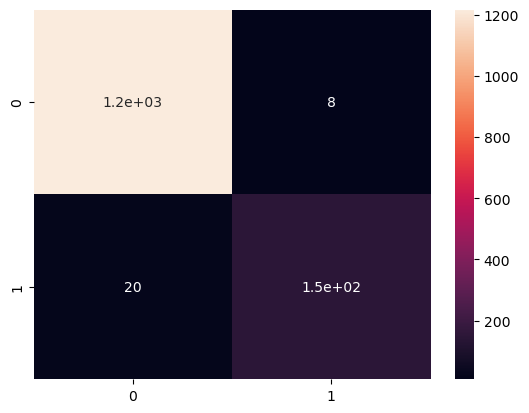

In [29]:
# Make predictions
lr_w2v = RandomForestClassifier()
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)

## Exercise - Word2Vec

Use the newsgroup data and Word2Vec to make predictions.

In [30]:
# Prepare datsets and Tokenize
tok = lemmaTokenizer(stop_words)
X_w2v_news_train = [tok(x) for x in data_train.data]
X_w2v_news_test = [tok(x) for x in data_test.data]

y_train_news = data_train.target
y_test_news = data_test.target

In [31]:
# Preview
X_w2v_news_train[0]

['Benedikt',
 'Rosenau',
 'writes',
 'great',
 'authority',
 'Contradictory',
 'property',
 'language',
 'If',
 'correct',
 'THINGS',
 'DEFINED',
 'BY',
 'CONTRADICTORY',
 'LANGUAGE',
 'DO',
 'NOT',
 'EXIST',
 'object',
 'definition',
 'reality',
 'If',
 'amend',
 'THINGS',
 'DESCRIBED',
 'BY',
 'CONTRADICTORY',
 'LANGUAGE',
 'DO',
 'NOT',
 'EXIST',
 've',
 'come',
 'something',
 'plainly',
 'false',
 'Failures',
 'description',
 'merely',
 'failure',
 'description',
 'objectivist',
 'remember']

In [32]:
# create Word2vec model
model_news = Word2Vec(X_w2v_news_train, min_count=1, vector_size=200)
w2v_news = dict(zip(model_news.wv.index_to_key, model_news.wv.vectors)) 

In [33]:
#Word2vec
# Fit and transform
model_news_w = MeanEmbeddingVectorizer(w2v_news)
X_train_vectors_w2v_news = model_news_w.transform(X_w2v_news_train)
X_val_vectors_w2v_news = model_news_w.transform(X_w2v_news_test)

In [34]:
# Make predictions
news_clf = SVC(probability=True)
news_clf.fit(X_train_vectors_w2v_news, y_train_news)  #model

#Predict y value for test dataset
y_predict_news = news_clf.predict(X_val_vectors_w2v_news)
y_prob_news = news_clf.predict_proba(X_val_vectors_w2v_news)[:,1]
 

print(classification_report(y_test_news,y_predict_news))
print('Confusion Matrix:\n',confusion_matrix(y_test_news, y_predict_news))
 
fpr, tpr, thresholds = roc_curve(y_test_news, y_prob_news)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.56      0.94      0.70       319
           1       0.44      0.06      0.11       251

    accuracy                           0.55       570
   macro avg       0.50      0.50      0.40       570
weighted avg       0.51      0.55      0.44       570

Confusion Matrix:
 [[300  19]
 [236  15]]
AUC: 0.5268455956737315


## Pretrained Word2Vec Models

When we do the intial training of the word2vec model (not when we are making final predictions), we are using our corpus to generate the space and the embeddigns for all of our tokens. We can also download a pretrained model, that already has the N-dimensional space defined (when it was trained on some different data), and use that to generate our embeddings. This is a common practice, and can be a good way to get started. Gensim has several models that have been trained on varying amounts of data, they are listed here: https://github.com/RaRe-Technologies/gensim-data along with several other datasets that we could use to train a model. 

The differences with using this pretrained model (or an existing corpus below) are:
<ul>
<li> Above, when training word2vec with our data, we used our corpus to generate the space in which the tokens are placed, then calculate those embeddings for each token. 
<li> With a pretrained model, we are using the space that was generated by the model that was trained on some other data, then placing our tokens in that space. 
</ul>

So if we are using some text from wikipedia (like the second example), the space in which embeddings are made is defined by the text in wikipedia. So the "closeness" in meaning of words is based on what is in that corpus. We then take our tokens and calculate their embeddings in that space. The big advantage to this is someone else can train a model on lots of data, which hopefully generates a better understanding of the relationships between words, and we can then just score our words on those scales. This approach is common in large models, like text processing or image recognition, where the training load can be too large for "regular folk". We can also take these trained models and "customize" them to our data, we'll look at that with image recognition at the end of the semester. 

#### Use a Twitter Trained Model

We can try using a pretrained model that was trained on Twitter data. This model has been pretrained, so it already knows how to represent words, we will then feed it all of our tokens, and it will generate the embeddings for us.

In [1]:
# Downlaod the model and do a little test

import gensim.downloader as api
model_twit = api.load("glove-twitter-200")
model_twit.most_similar("FUCK")

[==================================================] 100.0% 758.5/758.5MB downloaded


KeyError: "Key 'FUCK' not present"

##### Generate Embeddings

The model exists, so we will use it to transform our tokens into numerical representations. Then we can go use those to make classifications.

In [36]:
w2v_twit = dict(zip(model_twit.index_to_key, model_twit.vectors))
model_twit_emb = MeanEmbeddingVectorizer(w2v_twit)

X_train_twit = model_twit_emb.transform(X_w2v_news_train)
X_test_twit = model_twit_emb.transform(X_w2v_news_test)

# Make predictions
twit_clf = SVC(probability=True)
twit_clf.fit(X_train_twit, y_train_news)  #model

# Predict y value for test dataset
y_predict_twit = twit_clf.predict(X_test_twit)

print(classification_report(y_predict_twit, y_test_news))

              precision    recall  f1-score   support

           0       0.93      0.58      0.71       517
           1       0.13      0.60      0.21        53

    accuracy                           0.58       570
   macro avg       0.53      0.59      0.46       570
weighted avg       0.86      0.58      0.67       570



### Premade Corpus

We can also train a model directly from a preexisting corpus, then generate our embeddings from that model. 

The "text8" corpus is a small corpus of text that is included with gensim. It is a small subset of Wikipedia.

In [37]:
corpus = api.load('text8')
model_corp = Word2Vec(corpus)

In [38]:
w2v_corp = dict(zip(model_corp.wv.index_to_key, model_corp.wv.vectors)) 
#Word2vec
# Fit and transform
model_corp_emb = MeanEmbeddingVectorizer(w2v_news)
X_train_vectors_w2v_corp = model_corp_emb.transform(X_w2v_news_train)
X_val_vectors_w2v_corp = model_corp_emb.transform(X_w2v_news_test)
X_train_vectors_w2v_corp.shape

(857, 200)

In [39]:
# Make predictions
news_clf_corp = SVC(probability=True)
news_clf_corp.fit(X_train_vectors_w2v_corp, y_train_news)  #model

#Predict y value for test dataset
y_predict_news_corp = news_clf.predict(X_val_vectors_w2v_corp)
y_prob_news_corp = news_clf.predict_proba(X_val_vectors_w2v_corp)[:,1]

print(classification_report(y_test_news,y_predict_news_corp))

              precision    recall  f1-score   support

           0       0.56      0.94      0.70       319
           1       0.44      0.06      0.11       251

    accuracy                           0.55       570
   macro avg       0.50      0.50      0.40       570
weighted avg       0.51      0.55      0.44       570



## NLP and Me!

As we see with things like chatGPT and the assortment of voice assistants, NLP is currently exploding in both capability and prevelence. Those other models are based on these concepts, but there are a few key differences that help those tools be more powerful:
<ul>
<li> They are trained on much larger datasets. Very, very, very large datasets. In NLP specifically, this helps because it can help address the problem with us having so many words, many of which aren't used super often - i.e. the fact that there are a lot of words that don't occur together in the same sentence. If the training data is massive (e.g. "the internet"), we massively reduce the impact of this problem, as we see each word many times. 
<li> The use of neural networks, in particular recurrant neural networks (RNNs) that are able to deal with data as a sequence, and "remember" other parts of a sequence of words. This helps these models understand the context of a sentence, and the relationships between words.
    <ul>
    <li> Of note with neural networks, especially those using massive training data sets, is that the first layers of the model can perform equivalent data prep work that we've done here. So the model is more able to deal with data in its raw form, and doesn't need to be preprocessed as much separately, in advance. 
    </ul>
<li> Manual intervention is used, humans provide examples of convesation, define labels, and evaluate the quality of the model's work. You may have heard news of Kenyans being paid low wages to label data for these models.
<li> Other model types are used to help, such as reinforcement learning. Responses that are good are rewarded, and those that are bad are punished. This helps the model learn what is good and what is bad. This is particularly useful for generative models, such as chatGPT.
</ul>

As noted, this stuff is actively being developed right now, and the more advanced the tool, the more likely we are to see innovation or specific interventions to correct issues. The foundations we have looked at here are the building blocks of that work. 